### Consumo de combustible: Análisis Exploratorio

In [1]:
import pandas as pd

consumo_2024 = pd.read_excel(
    './Datos_consumos/CONSUMO-HIDROCARBUROS-2024-12.xlsx',
    sheet_name='CONSUMO',
    header=6,
    parse_dates=['Fecha']
)

consumo_2025 = pd.read_excel(
    './Datos_consumos/VENTAS-HIDROCARBUROS-2025-05.xlsx',
    sheet_name='VENTAS_IMP',
    header=6,
    parse_dates=['Fecha']
)

consumo = pd.concat([consumo_2024, consumo_2025], ignore_index=True)
consumo.sort_values('Fecha', inplace=True)

consumo.set_index('Fecha', inplace=True)

diesel_cols = [c for c in consumo.columns if 'Diesel' in c]
consumo['Diesel'] = consumo[diesel_cols].sum(axis=1)

df_consumo = consumo.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Super',
    'Gas licuado de petróleo': 'Gas Licuado'
})[['Gasolina Regular', 'Gasolina Super', 'Diesel', 'Gas Licuado']]

df_consumo.head()


,Gasolina Regular,Gasolina Super,Diesel,Gas Licuado
Fecha,,,,
2000-01-01 00:00:00,202645.20,308156.82,634667.06,194410.476190
2000-02-01 00:00:00,205530.96,307766.31,642380.66,174710.552381
2000-03-01 00:00:00,229499.56,331910.29,699807.25,189234.066667
2000-04-01 00:00:00,210680.40,315648.08,586803.98,174330.607143
2000-05-01 00:00:00,208164.34,319667.97,656948.20,191745.147619


In [2]:
import pandas as pd

df_consumo.index = pd.to_datetime(df_consumo.index, errors='coerce')

df_consumo = df_consumo[df_consumo.index.notna()]

df_consumo = df_consumo[~df_consumo.index.duplicated(keep='first')]

df_consumo = df_consumo[df_consumo.index <= '2025-05-01']

print(df_consumo.shape)  
print("Desde", df_consumo.index.min(), "hasta", df_consumo.index.max())


(305, 4)
Desde 2000-01-01 00:00:00 hasta 2025-05-01 00:00:00


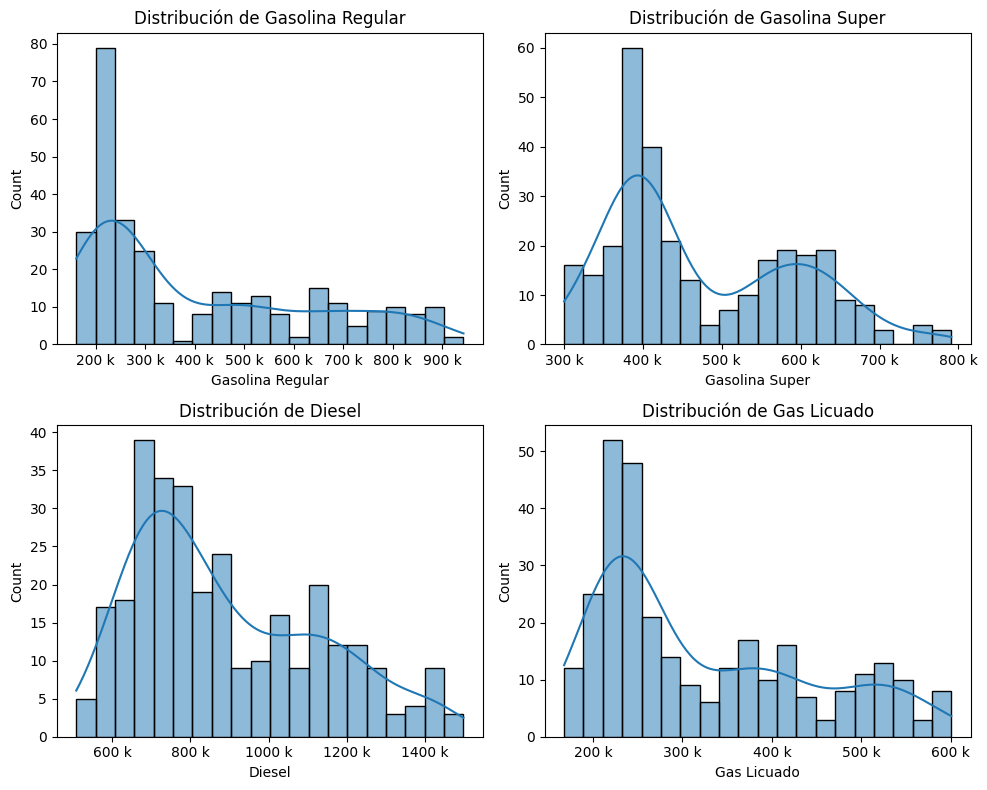

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

k_formatter = mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)} k')

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.flatten(), df_consumo.columns):
    sns.histplot(df_consumo[col], bins=20, kde=True, ax=ax)
    ax.set_title(f'Distribución de {col}')
    ax.xaxis.set_major_formatter(k_formatter)
plt.tight_layout()
plt.show()


Se puede observar como los cuatro tipos de combustible poseen una cola hacia la derecha, siendo más notaria en la Gasolina Regular lo cual indica que la mayoría de los meses concentra su consumo en valores bajos‐medios, pero que existen unos pocos meses con consumos excepcionalmente altos que extienden la cola hacia la derecha. Por otro lado vemos con la Super tiene sus picos en valores más altos y pareciera tener un segundo pico más amortiguado. El caso de Diesel es interesante porque parecer ser la que más amortiguación posee teniendo una cola no tan marcada, lo cual indica una distribución más amplia que las otras. Por último tenemos el gas licuado, el cual parece ser aún más estable.

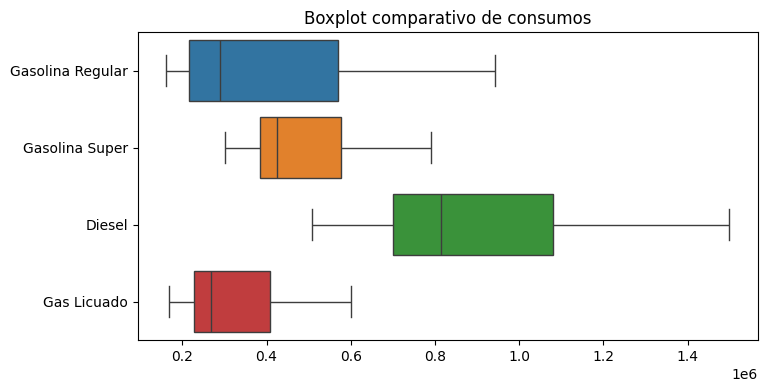

In [7]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_consumo, orient='h')
plt.title('Boxplot comparativo de consumos')
plt.show()





Se puede observar como Diesel es el conbustible que más consume, pero también es el mayor variabilidad. El caso contrario es el gas licuado, el cual es el menos consumido y también el que posee menor dispersión. En medio tenemos la gasolina Super y Regular, siendo Super ligeramente más estable que Regular, pero sin superar al Gas licuado.

Matriz de correlación:
                   Gasolina Regular  Gasolina Super    Diesel  Gas Licuado
Gasolina Regular          1.000000        0.936525  0.930957     0.982216
Gasolina Super            0.936525        1.000000  0.926488     0.925740
Diesel                    0.930957        0.926488  1.000000     0.916637
Gas Licuado               0.982216        0.925740  0.916637     1.000000 



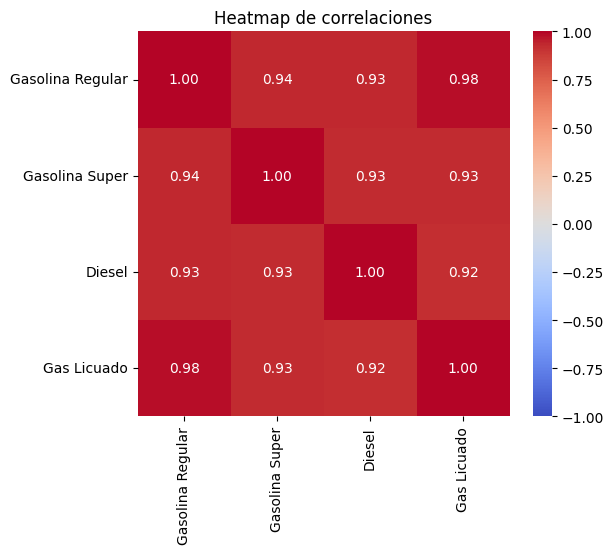

In [5]:
corr = df_consumo.corr()
print("Matriz de correlación:\n", corr, "\n")

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de correlaciones')
plt.show()


Se observa como los 4 tipos de combustible seleccionados poseen una correlación > .90 lo cual es bastante interesante, pero dentro de todas las correlaciones la qeu posee el valor más alto es la de gas licuado - gasolina Regular. Lo cual resulta interesante si contemplamos que el gas licuado es la más estable y Regular era la segunda más variada.

## Análisis de Serie

Inicio: 2000-01-01
Fin:    2025-05-01
Frecuencia: <MonthBegin>



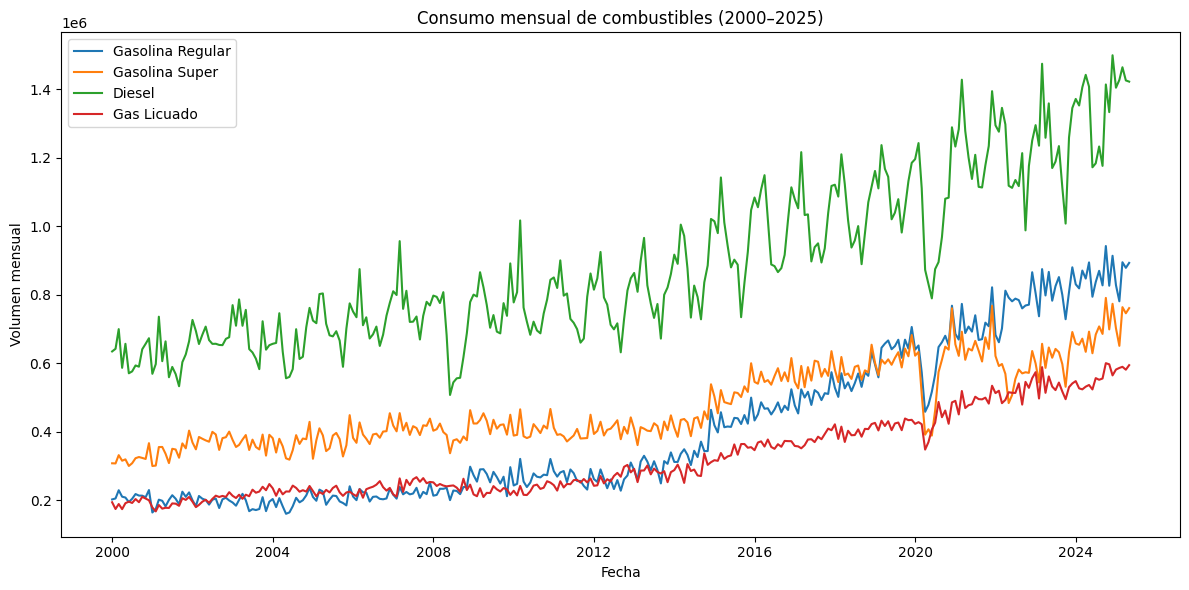

In [10]:
import matplotlib.pyplot as plt

inicio = df_consumo.index.min()
fin    = df_consumo.index.max()

frecuencia = 'MS'

df_consumo.index = pd.DatetimeIndex(df_consumo.index.values, freq=frecuencia)

print(f"Inicio: {inicio.date()}")
print(f"Fin:    {fin.date()}")
print(f"Frecuencia: {df_consumo.index.freq}\n")

plt.figure(figsize=(12, 6))
for col in df_consumo.columns:
    plt.plot(df_consumo.index, df_consumo[col], label=col)
plt.title('Consumo mensual de combustibles (2000–2025)')
plt.xlabel('Fecha')
plt.ylabel('Volumen mensual')
plt.legend()
plt.tight_layout()
plt.show()


Se observa como inicia el primero de enero del año 2000 y finaliza el primero de mayo del 2025, lo cual se alinea con lo esperado.  
Con respecto de la series se encuentra una ligera tendencia de crecimiento sobre las cuatro, siendo la más marcada de Diesel, esto podría indicarnos que a medida que avanzan los años han empezado a circular más carros que funcionan con Diesel, aunque también es cierto que desde un principio de la serie este ha sido el valor con más alto volumen. A primera vista puede ver un ligero patrón en donde los picos son muy similares y los valles son constantes, esto es algo que valdría la pena explorar a detalle. 
Super y Regular tienen un comportamiento similar, siendo Super ligeramente superior en los primeros años, pero teniendo una pequeña caída en los más recientes los cuales hacen que Regular tome la delantera. Además, se observa como en los años recientes llegaron a traslparse lo que nos muestra que los comportamientos son muy similares. 
Por último, el gas licuado es que menos tendencia marca, pero aún así se obsera como ha crecido, especilamente a partir del 2015, es ahí en donde el crecimiento se marca más.  
A simple vista se observan ciclos anuales: picos recurrentes en ciertos meses (posiblemente verano o fines de año) y valles en temporadas de menor consumo. 
La caída en 2020 puede atribuirse a la pandemia, pero se observa como en el siguiente se recupera.

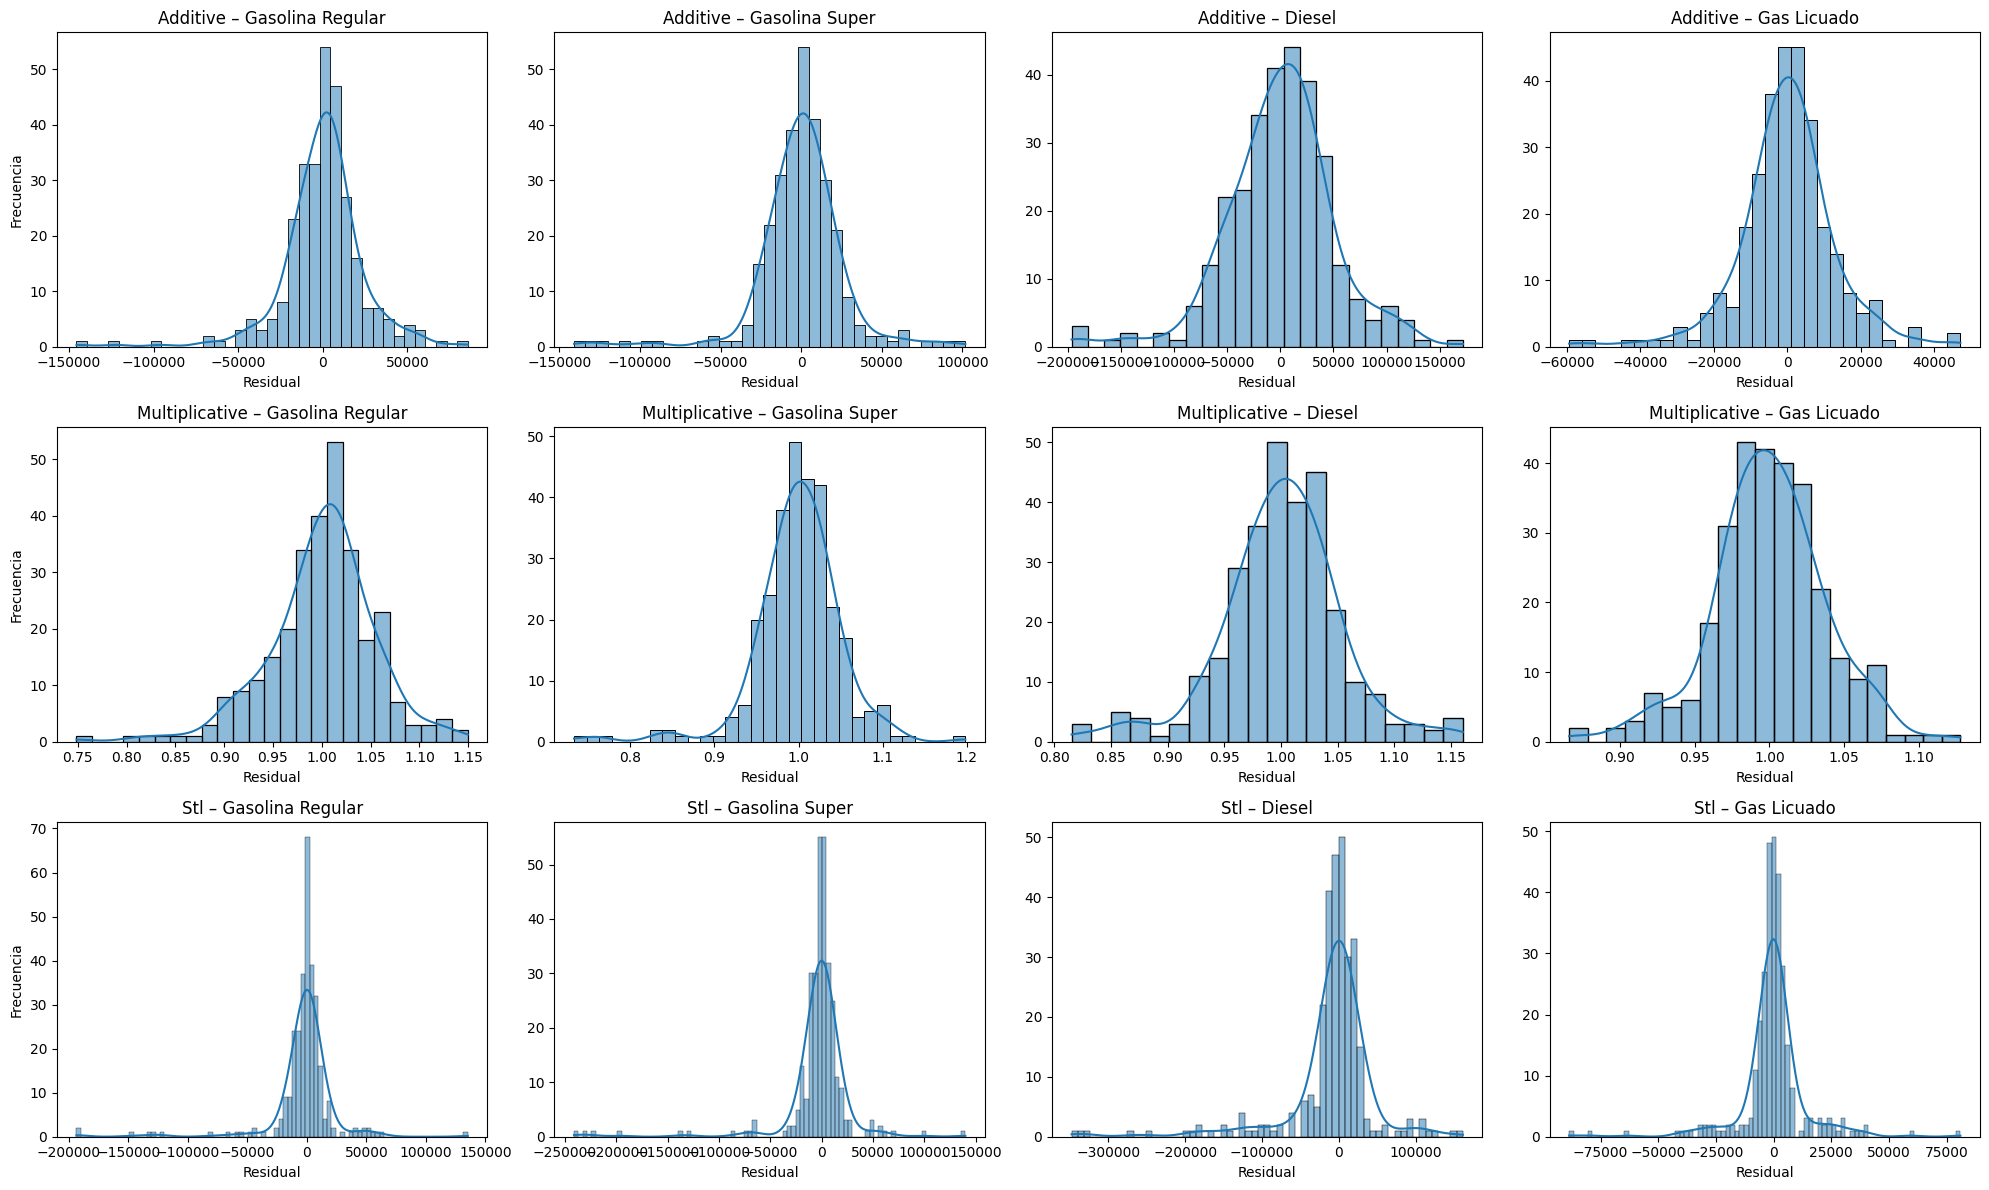

                        Media                                      Std  \
Método                    STL    additive multiplicative           STL   
Combustible                                                              
Diesel           -9984.355800  113.056313       1.000000  59602.853310   
Gas Licuado       -206.779209    3.693020       0.999833  14730.900592   
Gasolina Regular -2414.526305  125.635203       0.999890  27853.451001   
Gasolina Super   -3424.829777   13.508930       0.999715  33832.770090   

                                               
Método                additive multiplicative  
Combustible                                    
Diesel            50537.301590       0.053670  
Gas Licuado       13037.948825       0.038272  
Gasolina Regular  24169.838406       0.054516  
Gasolina Super    26820.454099       0.051546  


In [15]:
# ─── Bloque X: Evaluación de residuos para modelos aditivo, multiplicativo y STL ───
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL

periodo = 12
metodos = ['additive', 'multiplicative', 'STL']
residuos_summary = []

# Prepara una figura con filas = métodos y columnas = combustibles
fig, axes = plt.subplots(len(metodos), len(df_consumo.columns), figsize=(20, 12))

for i, metodo in enumerate(metodos):
    for j, col in enumerate(df_consumo.columns):
        # Descomposición según el método
        if metodo in ['additive', 'multiplicative']:
            res = seasonal_decompose(df_consumo[col], model=metodo, period=periodo)
            resid = res.resid.dropna()
        else:
            stl = STL(df_consumo[col], period=periodo, robust=True)
            fit = stl.fit()
            resid = fit.resid.dropna()
        # Guardar estadísticas
        residuos_summary.append({
            'Método': metodo,
            'Combustible': col,
            'Media': resid.mean(),
            'Std': resid.std()
        })
        # Histograma de residuos
        ax = axes[i, j]
        sns.histplot(resid, kde=True, ax=ax)
        ax.set_title(f"{metodo.capitalize()} – {col}")
        ax.set_xlabel('Residual')
        ax.set_ylabel('Frecuencia' if j == 0 else '')

fig.tight_layout()
plt.show()

# Crear y mostrar un resumen tabular de medias y desviaciones
res_df = pd.DataFrame(residuos_summary)
resumen = res_df.pivot(index='Combustible', columns='Método', values=['Media', 'Std'])
print(resumen)


Se realizó una tabla para comparar cuál de los tres modelos sería el ideal para la descomposición. Lo que se busca es método que tenga media lo más cercana posible al valor teórico (0 o 1), y tenga la desviación estándar más baja de todos. En este caso el que más se adecua es el modelo aditivo.

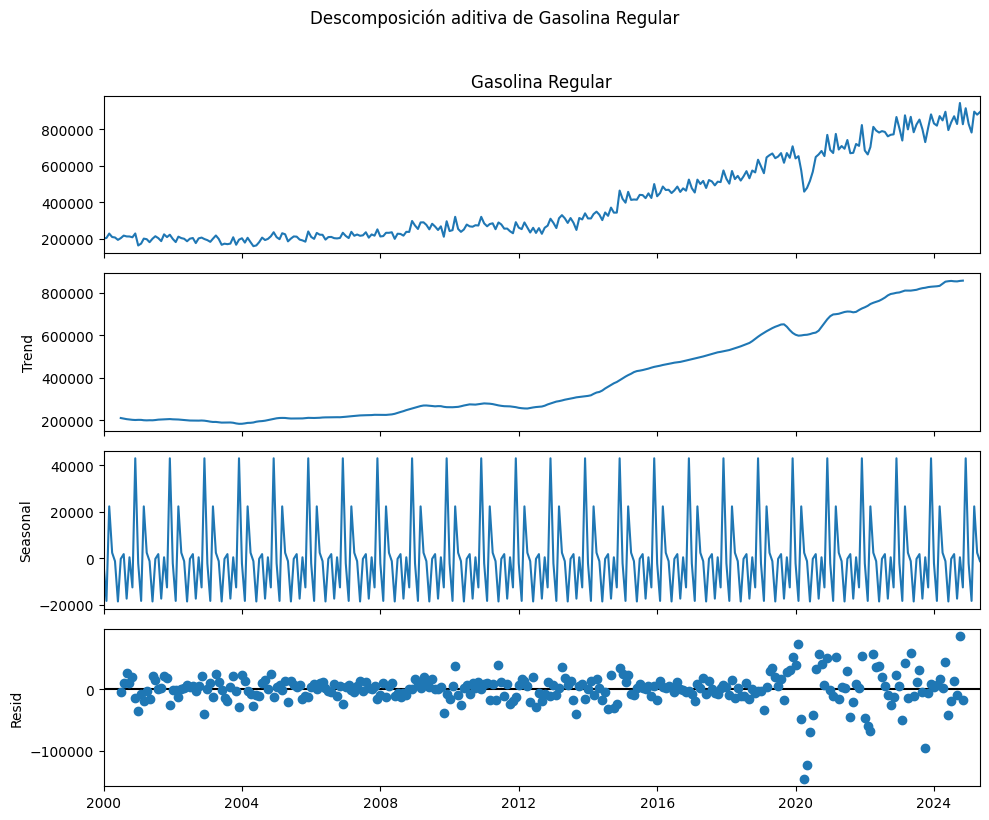

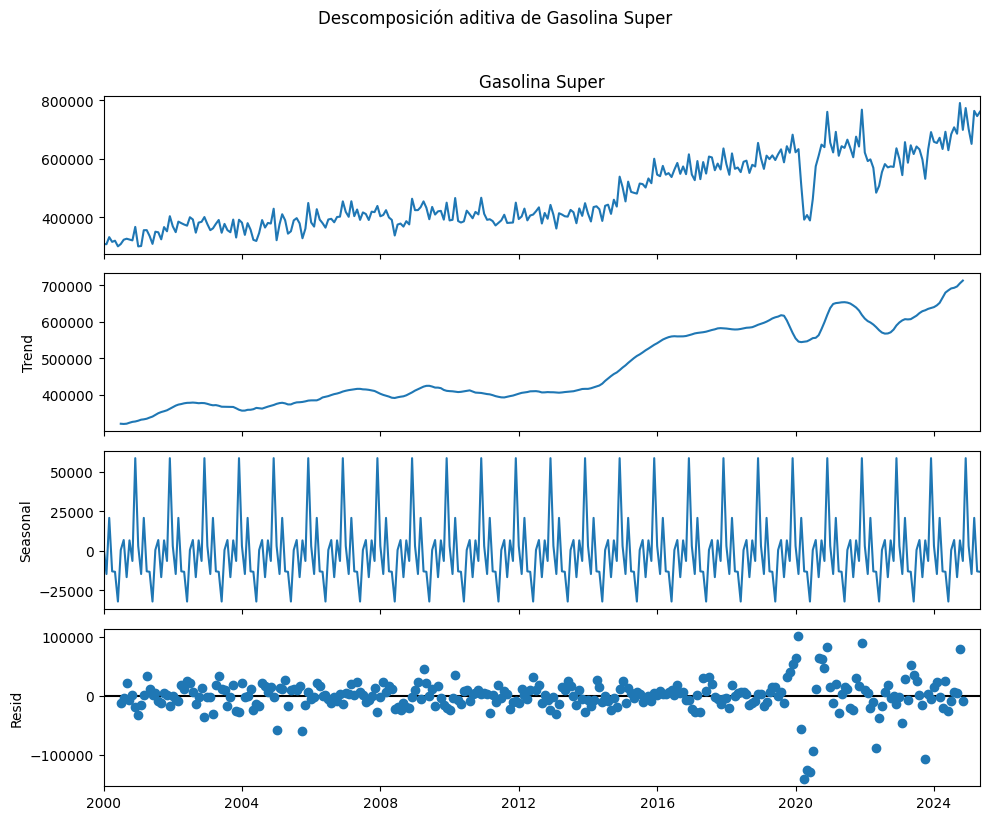

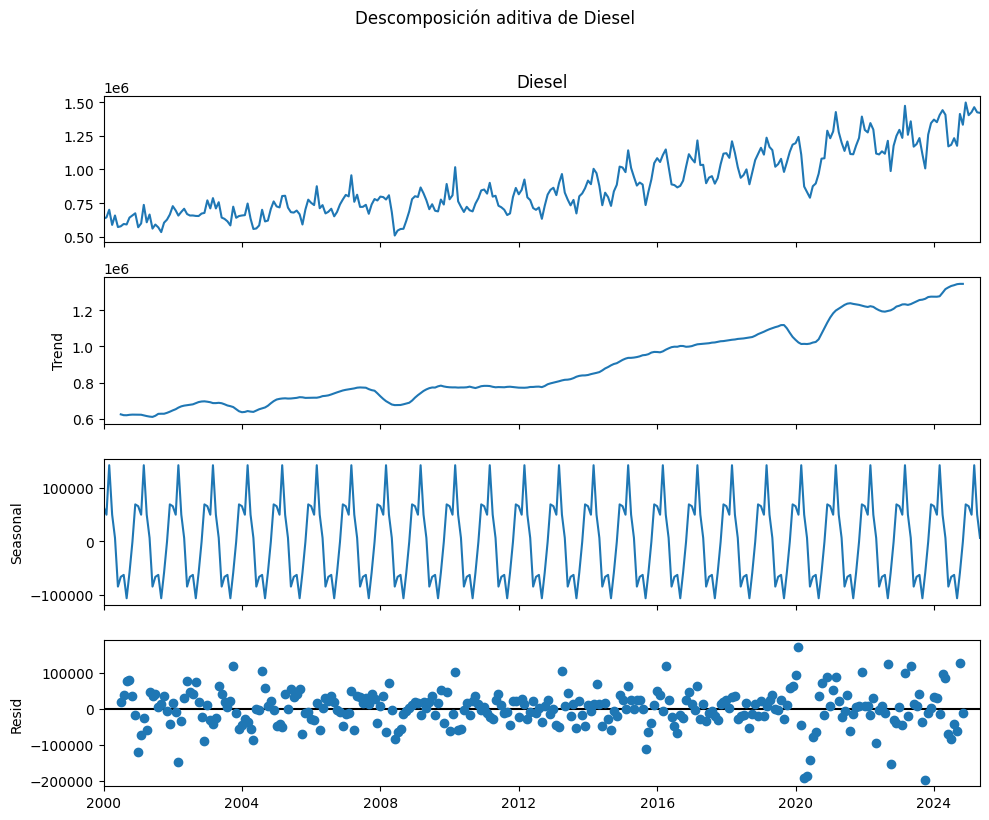

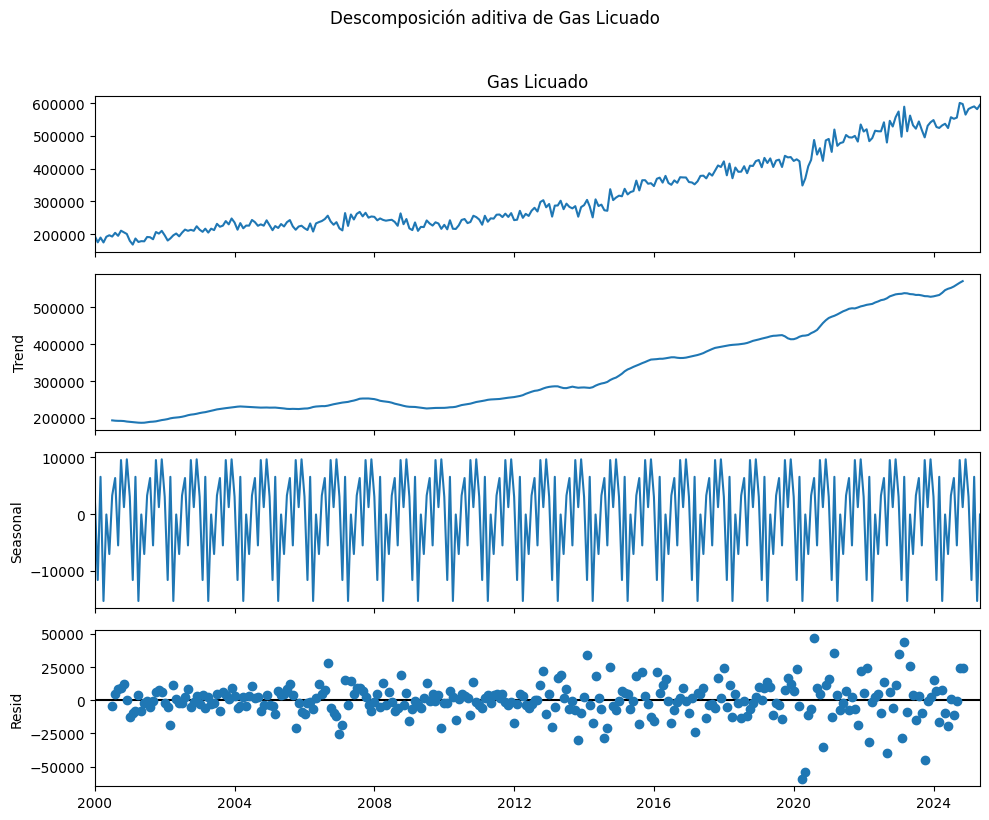

In [16]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

periodo = 12

for col in df_consumo.columns:
    result_add = seasonal_decompose(
        df_consumo[col],
        model='additive',
        period=periodo
    )
    fig = result_add.plot()
    fig.set_size_inches(10, 8)
    fig.suptitle(f'Descomposición aditiva de {col}', y=1.02)
    plt.tight_layout()
    plt.show()



Se observa como al descomponer la serie de la gasolina Regular se presenta tendencia plana al inicio, 2000 - 2010, que se acelera a partir del 2011 y 2019 y refleja el valle de la pandemia. Acerca de la estacionalidad, muestra un ciclo anual muy consistente, con picos y valles de ±20 000–25 000 unidades que se repiten cada año. Los residuos están centrados en cero y con varianza estable salvo por algunos outliers (especialmente en 2020–2022) lo que significa que el modelo captura correctamente la estructura sistemática de la serie.  
La serie descompuesta de la gasolina Super muestra una muy ligera tendencia creciente al inicio, del 2000 - 2014 esta se mantiene constante, a partir del 2015 su crecimiento aumenta, pasando también por el valle del 2020. En estacionalidad el ciclo anual es muy parecido al de la Regular comprobando que estos combustibles tienen un compartamiento muy similar. Sus residuos están centrados en cero, pero también es afectada por los outliners que afectan a la Regular.  
Diesel refleja una tendencia ligeramente pronunciada y con dos valles hasta 2013, a apartir de ese año su crecimiento es más acelerado, pero sin omitir el valle del 2020. Su comportamiento estacional consta de picos que oscilan entre las -100,000 - 100,000 unidades que se repiten cada años. Sus residuos están más disperos que los de la gasolina Super y Regular. Especialmente en los períodos del 2000-2008 y en 2020-2024 se disparan los outliners. 
El gas licuado muestra una tendencia claramente pronunciada desde 2001-2025, incluso el valle del 2020 no se tan marcado como en los otros combustibles, lo que nos demuestra que tuvo más estabilidad que los otros incluso en pandemia, un aspecto interesante a notar. La estacionalidad marca un comportamiento repetitivo a partir del 2001 con valores que oscilan entre -10,000-10,000. Sus residuos se muestran centrados en cero (con ligeros outliners) desde 2000-2012, en 2013 se dispara se empieza a ver más incertidumbre quesolo aumenta hasta llegar al 2025.

Ninguna de las cuatro series es estacionaria ni en media ni en varianza: todas muestran una clara tendencia a largo plazo (media que crece) y una amplitud estacional que tiende a aumentar con el nivel de la serie, lo que viola la constancia de varianza. Los residuos del modelo aditivo, aunque centrados en cero, presentan varianza creciente en los periodos de mayor tendencia y varios outliers (por ejemplo 2020–2022), confirmando heterocedasticidad. Por tanto, para aproximarnos a la estacionariedad convendría primero estabilizar la varianza para eliminar la tendencia y la componente cíclica; solo así podremos trabajar con series estacionarias en media y varianza para modelos ARIMA o de forecasting basados en ruido blanco.


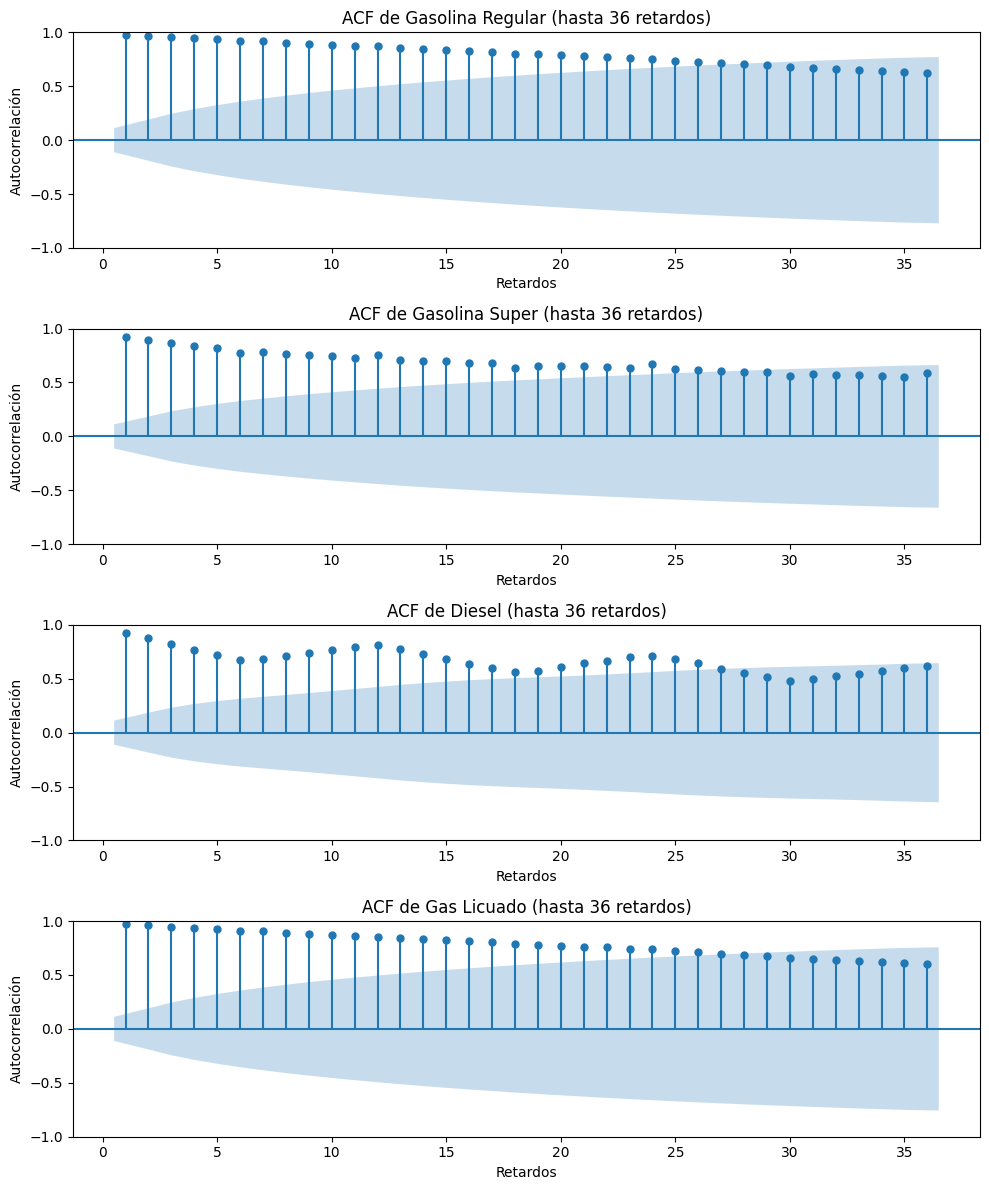

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(len(df_consumo.columns), 1, figsize=(10, 12))

for ax, col in zip(axes, df_consumo.columns):
    plot_acf(df_consumo[col], lags=36, ax=ax, zero=False)
    ax.set_title(f'ACF de {col} (hasta 36 retardos)')
    ax.set_xlabel('Retardos')
    ax.set_ylabel('Autocorrelación')

plt.tight_layout()
plt.show()


El autocorrelgrama muestra un lag bastante alto para los cuatro tipos de combustibles, lo cual demuestra que la serie no es estacionaria: las barras de autocorrelación permanecen por encima de la banda de confianza incluso en retardos de 12, 24 o 36 meses, indicando que el consumo de un mes arrastra con fuerza la influencia de valores muy lejanos (memoria de largo plazo) y que el nivel promedio cambia con el tiempo. 

In [ ]:
from statsmodels.tsa.stattools import adfuller

for col in df_consumo.columns:
    adf_res = adfuller(df_consumo[col].dropna())
    print(f"{col}:")
    print(f"  ADF Statistic: {adf_res[0]:.4f}")
    print(f"  p-value:        {adf_res[1]:.4f}")
    print(f"  Critical Values:")
    for key, val in adf_res[4].items():
        print(f"    {key}: {val:.4f}")
    print("-" * 40)



Gasolina Regular:
  ADF Statistic: 2.2922
  p-value:        0.9990
  Critical Values:
    1%: -3.4531
    5%: -2.8716
    10%: -2.5721
----------------------------------------
Gasolina Super:
  ADF Statistic: -0.0291
  p-value:        0.9561
  Critical Values:
    1%: -3.4529
    5%: -2.8715
    10%: -2.5721
----------------------------------------
Diesel:
  ADF Statistic: 0.5563
  p-value:        0.9865
  Critical Values:
    1%: -3.4529
    5%: -2.8715
    10%: -2.5721
----------------------------------------
Gas Licuado:
  ADF Statistic: 1.5592
  p-value:        0.9977
  Critical Values:
    1%: -3.4525
    5%: -2.8713
    10%: -2.5720
----------------------------------------


La prueba de Dickey–Fuller  demuestra que ninguna de las cuatro series es estacionaria en media, en todos los casos el estadístico ADF queda por encima de los valores críticos (1 %, 5 % y 10 %) y los p-values son muy altos (≈0.95–0.999), por lo que no podemos rechazar la hipótesis nula de raíz unitaria.  
Para lograr estacionariedad en media será necesario diferenciar cada serie y luego volver a aplicar la prueba ADF, buscando esta vez un estadístico menor que el valor crítico y un p-value < 0.05.

In [22]:
# ─── Bloque X: Diferenciación y nueva prueba ADF ───
from statsmodels.tsa.stattools import adfuller

# 1. Diferenciar las series para eliminar la tendencia
df_consumo_diff = df_consumo.diff().dropna()

# 2. Aplicar ADF a cada serie diferenciada
for col in df_consumo_diff.columns:
    adf_res = adfuller(df_consumo_diff[col])
    print(f"{col} (diferenciada):")
    print(f"  ADF Statistic: {adf_res[0]:.4f}")
    print(f"  p-value:       {adf_res[1]:.4f}")
    print("  Critical Values:")
    for key, val in adf_res[4].items():
        print(f"    {key}: {val:.4f}")
    print("-" * 40)


Gasolina Regular (diferenciada):
  ADF Statistic: -4.3503
  p-value:       0.0004
  Critical Values:
    1%: -3.4533
    5%: -2.8717
    10%: -2.5722
----------------------------------------
Gasolina Super (diferenciada):
  ADF Statistic: -4.3502
  p-value:       0.0004
  Critical Values:
    1%: -3.4533
    5%: -2.8717
    10%: -2.5722
----------------------------------------
Diesel (diferenciada):
  ADF Statistic: -7.2644
  p-value:       0.0000
  Critical Values:
    1%: -3.4529
    5%: -2.8715
    10%: -2.5721
----------------------------------------
Gas Licuado (diferenciada):
  ADF Statistic: -9.6341
  p-value:       0.0000
  Critical Values:
    1%: -3.4525
    5%: -2.8713
    10%: -2.5720
----------------------------------------


Se aplicó una diferenciación para ajustar los valores, la cual demostró una alta efectiviadd, ya que ahora los estadísticos ADF son menos que los valores críticos al 1% y lo p-values son casi 0, por lo que se rechaza la hipótesis nula de raiz unitaria en cada serie.